In [691]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

In [759]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

In [929]:
def print_correlation(data, threshold):
    corr = data.corr(method='pearson').abs()
    np.fill_diagonal(corr.values, np.nan)
    corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
    print(corr[corr > threshold])

def plot_correlation(data):
    plt.figure(figsize=(4,4))
    sns.heatmap(data.corr(method='pearson').abs(), square=True)

def plot_scatter(x, y, data):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=x, y=y, data=data)

In [930]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [931]:
data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

In [932]:
print_correlation(data[num_cols], 0.6)

ClientPeriod     TotalSpent    0.826332
MonthlySpending  TotalSpent    0.652034
dtype: float64


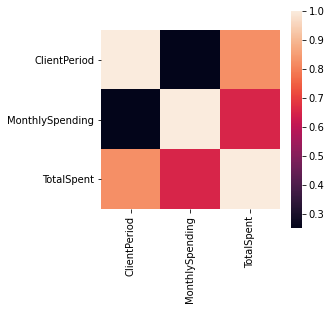

In [933]:
plot_correlation(data[num_cols])

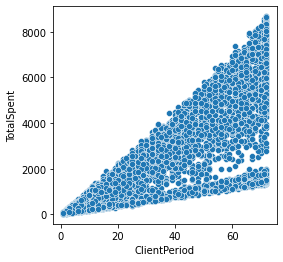

In [934]:
plot_scatter('ClientPeriod', 'TotalSpent', data)

In [935]:
def extract_features(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
    data[cat_cols] = data[cat_cols].fillna(data[num_cols].median()[0])
    data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 13).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], 5).astype(str)
    data['TotalSpentG'] = pd.cut(data['TotalSpent'], 5).astype(str)
    return data

def predict_data(model, test_data):
    submission = pd.read_csv('./submission.csv')
    submission['Churn'] = model.predict_proba(test_data)[:,1]
    submission.to_csv('./my_submission.csv', index=False)

In [936]:
test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')
test_data = extract_features(test_data)
train_data = extract_features(train_data)

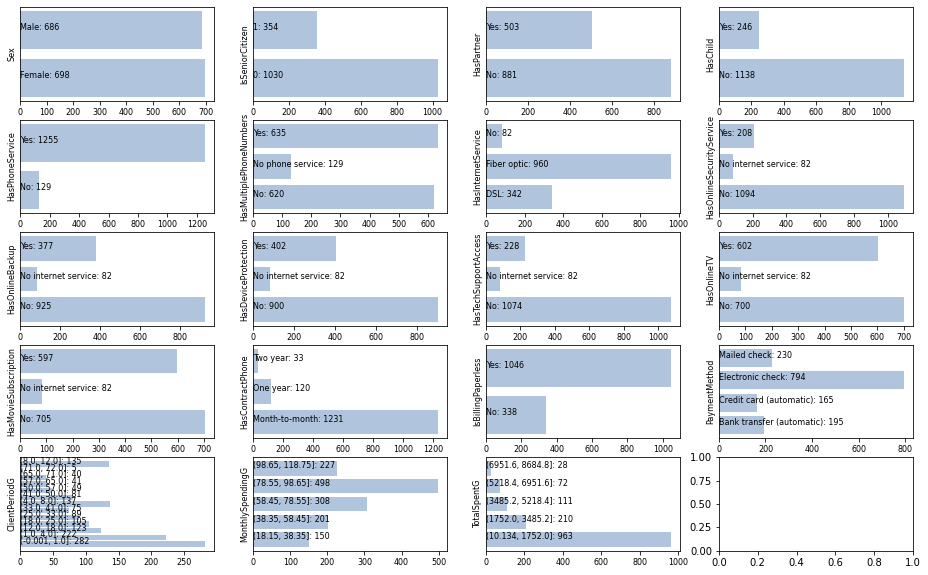

In [937]:
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG','TotalSpentG']
fig, axes = plt.subplots(5, 4, figsize=(16,10))
for c, ax in zip(cat_cols_, axes.flat):
    cnt = train_data.groupby(c)['Churn'].sum()
    ax.barh(cnt.index, cnt.values, color='lightsteelblue')
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylabel(c, fontsize=8)
    ax.set_yticks([])
    z = zip(range(len(cnt)), cnt.index, cnt.values)
    for i, k, v in z: ax.text(0, i, f'{k}: {v}', fontsize=8)

In [942]:
cat_cols_ = cat_cols + ['ClientPeriodG'] # 'MonthlySpendingG'
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = LogisticRegression(C=1, solver='liblinear')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
cross_val_score(model, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=5).mean()

0.8495675734307294

In [943]:
model.fit(train_data[cat_cols_], train_data[target_col])
predict_data(model, test_data[cat_cols_])

In [917]:
cat_cols_ = cat_cols + ['ClientPeriodG'] # 'MonthlySpendingG'
catboost = CatBoostClassifier(learning_rate=0.1, num_trees=100)
catboost.set_params(cat_features=cat_cols_, silent=True)
cross_val_score(catboost, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=5).mean()

0.8468759870857776

In [918]:
model.fit(train_data[cat_cols_], train_data[target_col])
predict_data(model, test_data[cat_cols_])

In [919]:
num_cols_ = ['ClientPeriod'] # 'MonthlySpending'
catboost = CatBoostClassifier(learning_rate=0.1, num_trees=100)
catboost.set_params(cat_features=cat_cols, silent=True)
cross_val_score(catboost, train_data[cat_cols + num_cols_], train_data[target_col], scoring='roc_auc', cv=5).mean()

0.8480473555677562

In [870]:
cat_cols_ = cat_cols + ['ClientPeriodG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = RandomForestClassifier(n_estimators=200, max_depth=5, criterion='entropy')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
cross_val_score(model, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=5).mean()

0.8368329285665655

In [871]:
cat_cols_ = cat_cols + ['ClientPeriodG']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols_)])
classifier = KNeighborsClassifier(n_neighbors=129, metric='euclidean')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
cross_val_score(model, train_data[cat_cols_], train_data[target_col], scoring='roc_auc', cv=5).mean()

0.8295112981784918

In [889]:
num_cols_ = ['ClientPeriod']
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols)])
classifier = KNeighborsClassifier(n_neighbors=128, metric='minkowski')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
cross_val_score(model, train_data[cat_cols + num_cols_], train_data[target_col], scoring='roc_auc', cv=5).mean()

0.8166229954371509

In [890]:
model.fit(train_data[cat_cols + num_cols_], train_data[target_col])
predict_data(model, test_data[cat_cols + num_cols_])

In [663]:
# sns.catplot(x='Churn', y='ClientPeriod', hue='Sex', kind='box', data=data)
# sns.catplot(x='Churn', y='MonthlySpending', hue='Sex', kind='box', data=data)
# sns.catplot(x='Churn', y='TotalSpent', hue='Sex', kind='box', data=data)
# (data['Churn']==1).sum(), (data['Churn']==0).sum()